In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
import seaborn as sns



2022-09-05 11:53:03.045243: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-05 11:53:03.119244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lepton/.pyenv/versions/3.8.12/envs/Anaemia_Classification/lib/python3.8/site-packages/cv2/../../lib64:
2022-09-05 11:53:03.119308: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:


# source_folder = r"/home/lepton/Desktop//"
# destination_folder = r"/home/lepton/code/vivekptl9/Anaemia_Classification//"

# # fetch all files
# for file_name in os.listdir(source_folder):
#     # construct full file path
#     source = source_folder + file_name
#     destination = destination_folder + file_name
#     # copy only files
#     if os.path.isfile(source):
#         sht.copy(source, destination)
#         print('copied', file_name)

In [3]:
with open('/home/lepton/Downloads/Anaemia/Anaemia/pictures_array.npy', 'rb') as f:
    pics_all = np.load(f)
with open('/home/lepton/Downloads/Anaemia/Anaemia/labels_array.npy', 'rb') as f:
    labels_all = np.load(f)

In [4]:
pics_all[0].shape

(224, 224, 3)

In [5]:
train_set = pics_all[0:1200]
test_set = pics_all[1200: 1500]
train_labels = labels_all[0:1200]
test_labels = labels_all[1200: 1500]

print(len(train_set))
print(len(train_labels))
print(len(test_set))
print(len(test_labels))

1200
1200
300
300


In [6]:
x_train,y_train,x_test,y_test = train_set,train_labels, test_set, test_labels

In [7]:
activation = 'sigmoid'
feature_ext = Sequential()
feature_ext.add(Conv2D(200,3,activation = activation,padding = "same", input_shape=(224, 224, 3)))

feature_ext.add(Conv2D(150, kernel_size=(3, 3), activation=activation, padding = 'same'))
#   

feature_ext.add(Conv2D(100, kernel_size=(3), activation=activation)) # kernel_size = 3 <==> (3, 3)
#feature_ext.add(layers.MaxPool2D(pool_size=(2,2))) 

feature_ext.add(Conv2D(50, kernel_size=(3), activation=activation)) #kernel_size = 3 <==> (3, 3)
#feature_ext.add(layers.MaxPool2D(pool_size=(2,2))) 

feature_ext.add(Conv2D(20, kernel_size=(3), activation=activation)) # kernel_size = 3 <==> (3, 3)
#feature_ext.add(layers.MaxPool2D(pool_size=(2,2))) 

feature_ext.add(Flatten())

2022-09-05 11:53:15.041224: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-05 11:53:15.041275: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vivek-lepton): /proc/driver/nvidia/version does not exist
2022-09-05 11:53:15.043005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
x = feature_ext.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(1, activation = "sigmoid")(x)

# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_ext.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'binary_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 200)     5600      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 150)     270150    
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 100)     135100    
                                                                 
 conv2d_3 (Conv2D)           (None, 220, 220, 50)      45050     
                                                                 
 conv2d_4 (Conv2D)           (None, 218, 218, 20)      9020      
                                                                 
 flatten (Flatten)           (None, 950480)            0     

In [25]:
history = cnn_model.fit(x_train, y_train, epochs=50, validation_data = (x_test, y_test))

Epoch 1/50
38/38 [==============================] - 1198s 31s/step - loss: 2.2392 - accuracy: 0.5867 - val_loss: 0.8532 - val_accuracy: 0.8067
Epoch 2/50
38/38 [==============================] - 1109s 29s/step - loss: 1.3629 - accuracy: 0.5967 - val_loss: 0.5250 - val_accuracy: 0.8067
Epoch 3/50
38/38 [==============================] - 784s 21s/step - loss: 0.7821 - accuracy: 0.5967 - val_loss: 0.5408 - val_accuracy: 0.8067
Epoch 4/50
38/38 [==============================] - 944s 25s/step - loss: 0.6769 - accuracy: 0.5967 - val_loss: 0.5621 - val_accuracy: 0.8067
Epoch 5/50
38/38 [==============================] - 1127s 30s/step - loss: 0.6766 - accuracy: 0.5967 - val_loss: 0.5971 - val_accuracy: 0.8067
Epoch 6/50
 5/38 [==>...........................] - ETA: 13:53 - loss: 0.6613 - accuracy: 0.6375

In [8]:
x_for_RF = feature_ext.predict(x_train)

38/38 [==============================] - 347s 9s/step


In [9]:
x_for_RF.shape

(1200, 950480)

In [10]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_estimators=50,random_state=42)
RF_model.fit(x_for_RF,y_train)


RandomForestClassifier(n_estimators=50, random_state=42)

In [11]:

x_test_feature = feature_ext.predict(x_test)

10/10 [==============================] - 89s 9s/step


In [12]:
x_test_feature.shape

(300, 950480)

1/1 [==============================] - 1s 552ms/step
The predicted label for this image is:  0
The actual label for this image is:  0


(224, 224, 3)

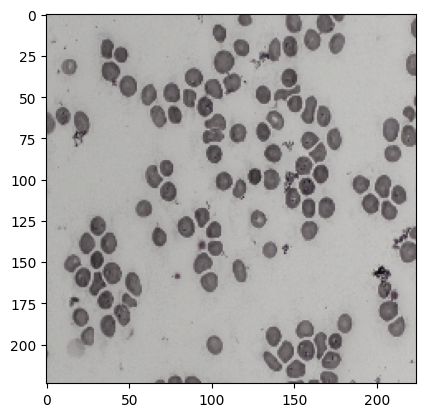

In [19]:
n=75#Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_ext.predict(input_img)
prediction_RF = RF_model.predict(input_img_features)[0] 
#prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The predicted label for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])
img.shape

In [14]:
prediction_RF = RF_model.predict(x_test_feature)
prediction_RF.shape

(300,)

In [15]:
from sklearn import metrics

print("Accuracy = ", metrics.accuracy_score(test_labels,prediction_RF))

Accuracy =  0.8966666666666666
